# Aprendizaje Formal

## Práctica 7: Redes neuronales y clasificación de dígitos

En esta práctica vamos a tratar con el problema de reconocimiento de dígitos para lo cual implementaremos una red neuronal, con la propagación hacia adelante y hacia atrás. Además, implementaremos las versiones con y sin regularización de la función de coste y la inicialización aleatoria de los pesos. Finalmente, utilizaremos la red para realizar predicciones.

## Índice de la práctica

- [Lectura y visualización de datos](#Lectura-y-visualización-de-datos)
- [Implementación de una Red Neuronal Multicapa](#Implementación-de-una-Red-Neuronal-Multicapa)
- [Propagación hacia adelante (feed-forward)](#Propagación-hacia-adelante---feed-forward)
    - [Función de coste](#Función-de-coste)
    - [Función de coste con regularización](#Función-de-coste-con-regularización)
    - [Propagación hacia atrás (backpropagation)](#Propagación-hacia-atrás---backpropagation )
    - [Propagación hacia atrás (backpropagation) con regularización](#Propagación-hacia-atrás---backpropagation---con-regularización)
- [Entrenamiento de la red y clasificación](#Entrenamiento-de-la-red-y-clasificación)
- [Tarea opcional](#Tarea-opcional)



## Lectura y visualización de datos

El conjunto de datos está disponible en el fichero `ex7data` que como siempre leeremos con `loadtxt` (delimitado por comas). El conjunto de datos tiene 5000 ejemplos. La última columna contiene la clase (los dígitos de 0 a 9).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from test_helper import Test


# Lee los datos y guárdalos en data
data = np.loadtxt('ex7data.txt', delimiter=',')
X = data[:, :-1]
y = data[:, -1].reshape(-1, 1)
print(X.shape, y.shape)

(5000, 400) (5000, 1)


Para comprender mejor el problema con el que tratamos, vamos a comenzar mostrando los ejemplos que tenemos. Cada ejemplo está formado por 400 características, que son realmente las intensidades de cada píxel de una imagen de 20x20. Vamos a comprobar que esto es así mostrando diez ejemplos aleatorios (puedes ejecutar varias veces el código para ver diferentes ejemplos). En el título, aparece la clase real del ejemplo en cuestión.

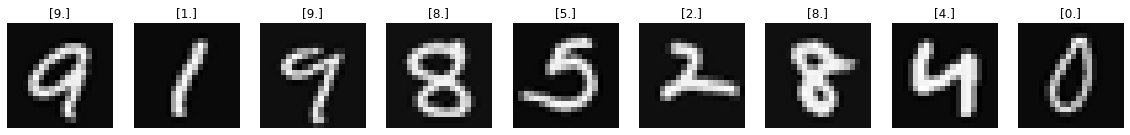

In [143]:
plt.figure(figsize=(20,2))

for degree in range(9):
    plt.subplot(191+degree)
    index = np.random.randint(0, X.shape[0])
    img = X[index, :].reshape(20, 20, order='F')
    plt.imshow(img, cmap=plt.cm.gray)
    plt.title(y[index])
    plt.axis('off')
plt.show()

¿Seremos capaces de entrenar una red que pueda distinguir el dígito que aparece en la imagen? Lo veremos a lo largo de la práctica.

# Implementación de una Red Neuronal Multicapa

Como hemos visto en teoría, para trabajar con problemas multi-clase con redes neuronales necesitamos transformar la salida que es un solo valor (la clase) a un vector de 0s y 1s, en donde el 1 en la posición correspondiente nos indique a qué clase pertenece el ejemplo. Esto es necesario ya que vamos a tener una neurona de salida para cada una de las clases.

Para lograr esta transformación vamos a usar el método OneHotEncoder de scikit, que hace precísamente esa tarea. One-hot enconding convierte una etiqueta de clase $n$ (de entre $k$ clases) en un vector de longitud $k$ donde el índice $n$ está "hot" (activado, es decir, a 1), mientras que el resto están a 0.

In [3]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
# Aplica el fit_transform de scikit a y para obtener el nuevo y_onehot
y_onehot = encoder.fit_transform(y)
print(y_onehot.shape)
print(y[0], y_onehot[0,:])

(5000, 10)
[0.] [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [4]:
Test.assertEquals(list(y_onehot[0,:]), [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.], 'One-hot encoding incorrecto')

1 test passed.


La red neuronal que vamos a construir para este ejercicio tiene tantas neuronas de entrada como características tienen nuestros ejemplos (400 + la unidad de bias). La capa oculta tendrá 25 neuronas (26 con el bias), y la capa de salida tendrá 10 neuronas, que cada una de ellas corresponde a una de las clases. 

Lo primero que debemos haces es implementar la función de coste para evaluar el coste para un conjunto de parámetros dado. Para ello, primero necesitamos aplicar la propagación hacia adelante, que nos de la salida para cada ejemplo de entrada.

Vamos por pasos. Comenzamos implementando la función sigmoide.

$$ g(z) = \frac{1}{1+e^{-z}} $$

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

## Propagación hacia adelante - feed-forward
A continuación, vamos a calcular la propagación hacia adelante. Para ello, recibimos la matriz con los datos $X$ y las dos matrices de pesos $\Theta^{(1)}$ y $\Theta^{(2)}$ (los pesos entre la capa de entrada y la capa oculta y los pesos entre la capa oculta y la de salida, respectivamente).

Debemos seguir los siguientes pasos:
1. Añadir el bias a todos los ejemplos de $X$ (la primera columna de 1s). Obtenemos $a^{(1)}$
2. Obtenemos $z^{(2)}=a^{(1)}·\Theta^{(1)}$
3. Obtenemos $a^{(2)}$ a partir de $z^{(2)}$ aplicando la sigmoide ($a^{(2)}=g(z^{(2)})$  y le añadimos el bias (primera columna de 1s).
4. Obtenemos $z^{(3)}=a^{(2)}·\Theta^{(2)}$
5. Obtenemos $h_{\Theta}(X)=g(z^{(3)})$

En $h_{\Theta}(X)$ tenemos por tanto una matriz de $5000\times 10$ con las salidas de las 10 neuronas para cada uno de los 5000 ejemplos. La siguiente figura clarifica el proceso.
![Feed Forward](img_forward.png)

In [6]:
def forward_propagate(X, theta1, theta2):
    m = X.shape[0]
    
    # Añadimos la columna de unos a X para obtener a1
    a1 = np.hstack((np.ones((m, 1)), X))
    # Calculamos z2 -> ten en cuenta que a1 tiene tantas filas como ejemplos y columnas como atributos + 1
    # Por otro lado, theta1 tiene tantas filas como neuronas en la capa oculta y columnas como atributos + 1
    z2 = np.dot(a1, theta1.T)
    # Añadimos la columna de unos a la sigmoide de z2 (que es a2) para obtener el a2 definitivo
    a2 = np.hstack((np.ones((z2.shape[0], 1)), sigmoid(z2)))
    # Calculamos z3
    z3 = np.dot(a2, theta2.T)
    # Obtenemos la salida final en h
    h = sigmoid(z3)
    
    return a1, z2, a2, z3, h

## Función de coste 

Con la propagación hacia adelante, ya podemos calcular la función de coste:
$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\big[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\big]$$

Aquí debemos tener cuidado porque para utilizar la función `minimize` de scipy, los parámetros $\Theta^{(1)}$ y $\Theta^{(2)}$ nos llegan en un único parámetro `params` y debemos desempaquetarlas. Además, hay que tener en cuenta que $y$ es una matriz de ejemplos x número de clases (5000x10 en este caso). Y por tanto, la salida que nos da la propagación hacia adelante que será de 5000x10 y la $y$ serán directamente comparables. La función de coste nos da una estimación de cómo de poco parecidas son $y$ y $h_\Theta(X)$.

In [36]:
def cost(params, input_size, hidden_size, num_labels, X, y):
    m = X.shape[0]
    # Utilizamos las matrices de numpy por facilidad: * es el producto de matrices y np.multiply elemento por elemento
    X = np.matrix(X)
    y = np.matrix(y)
    
    # desempaquetamos las matrices con los parámetros para cada capa
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # Ejecutamos las propagación hacia adelante para obtener las salidas para cada ejemplo
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # Calculamos el coste
    J = -1 / m * np.sum(np.multiply(y, np.log(h)) + np.multiply((1 - y), np.log(1 - h)))
    
    return J

Vamos a comprobar que lo  implementado hasta ahora funciona correctamente (también devolvemos los pasos intermedio porque serán útiles más adelante).

In [50]:
# Configuración inicial
input_size = 400
hidden_size = 25
num_labels = 10
np.random.seed(123456789)

# Inicializamos los parámetros de la red aleatoriamente
# El tamaño del array es el tamaño de las dos matrices de pesos concatenadas
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.25

# Podemos desempaquetar los parámetros que acabamos de inicializar igual que lo hacemos en la función de coste
theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

# Veamos si los tamaños de las matrices theta1 y theta2 son correctos
theta1.shape, theta2.shape

((25, 401), (10, 26))

In [30]:
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
print(a1.shape, z2.shape, a2.shape, z3.shape, h.shape)

Test.assertEquals(list(np.round(h[55, :].tolist()[0], 4)), [ 0.4401, 0.5554, 0.3921, 0.4379,0.4063,  0.4987,  0.5222, 0.4887, 0.6124, 0.5376], 'Resultado de la propagación hacia adelante incorrecto')

(5000, 401) (5000, 25) (5000, 26) (5000, 10) (5000, 10)
1 test passed.


Sabiendo que la función de propagación hacia adelante funciona correctamente, veamos si la función de coste también funciona como debe.

In [37]:
error = cost(params, input_size, hidden_size, num_labels, X, y_onehot)
print(error)

6.8223773858037955


In [38]:
Test.assertEquals(round(error, 4), 6.8224, 'Función de coste incorrecta')

1 test passed.


## Función de coste con regularización

Una vez implementada la función de coste sin regularización, vamos a pasar a la versión regularizada. Realmente el único cambio es que debemos sumar la parte correspondiente a la regularización (la suma de los parámetros al cuadrado sin contar los que corresponden a los bias).

$$ J(\theta) = \frac{1}{m}\sum_{i=1}^{m}\sum_{k=1}^{K}\bigg[-y^{(i)}_{k}\, log\,(( h_\theta\,(x^{(i)}))_k)-(1-y^{(i)}_k)\,log\,(1-h_\theta(x^{(i)}))_k)\bigg] + \frac{\lambda}{2m}\bigg[\sum_{j=1}^{25}\sum_{k=1}^{400}(\Theta_{j,k}^{(1)})^2+\sum_{j=1}^{10}\sum_{k=1}^{25}(\Theta_{j,k}^{(2)})^2\bigg]$$

In [52]:
def costReg(params, input_size, hidden_size, num_labels, X, y, lambda_reg):
    m = X.shape[0]
    # Utilizamos las matrices de numpy por facilidad: * es el producto de matrices y np.multiply elemento por elemento
    X = np.matrix(X)
    y = np.matrix(y)
    
    # desempaquetamos las matrices con los parámetros para cada capa, obtener theta1 y theta2
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    # Ejecutamos las propagación hacia adelante para obtener las salidas para cada ejemplo
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    # Calculamos el coste
    # Añadir a lo implementado anteriormente el término de regularización
    # Es decir, la suma de los parámetros al cuadrado sin considerar la primera columna en ninguna de las dos matrices de parámetros
    reg = lambda_reg / (2 * m) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:])) )
    J = -1 / m * np.sum(np.multiply(y, np.log(h)) + np.multiply((1 - y), np.log(1 - h))) + reg
    
    return J

In [53]:
# Establecemos el valor de lambda
lambda_reg = 1.0
error = costReg(params, input_size, hidden_size, num_labels, X, y_onehot, lambda_reg)
print(error)

6.827724308940754


In [54]:
Test.assertEquals(round(error, 4), 6.8277, 'Función de coste incorrecta')

1 test passed.


## Propagación hacia atrás - backpropagation
A continuación debemos implementar el algoritmo de backprogation (propagación hacia atrás). Esta parte del algoritmo calcula la actualización de los parámetros con el objetivo de reducir el error sobre el conjunto de entrenamiento. 

En primer lugar necesitamos calcular el gradiente de la función sigmoide que hemos implementado antes:
$$ g'(z) = g(z)(1 - g(z))$$

**Ten en cuenta que debes aplicar el producto elemento por elemento (con `np.multiply`).**

In [55]:
def sigmoid_gradient(z):
    return np.multiply(sigmoid(z), 1 - sigmoid(z))

Ahora ya podemos implementar la propagación hacia atrás para calcular los gradientes. Como los cálculos requeridos por backpropagation involucran a todos los calculos realizados en la función de coste, vamos realmente a extender la función de coste que acabamos de implementar para que también calcule la propagación hacia atrás y devuelva el coste y los gradientes (de tal forma que luego podamos usar `minimize`).

![Backpropagation](img_backprop.png)

**Algoritmo**

Inicializamos $\Delta^{(1)}_{ij}$ y $\Delta^{(2)}_{ij}$ a 0 (lo utilizamos para calcular el gradiente)

Para cada ejemplo $i=0,...,m$
1. Calculamos el error en la capa de salida $$\delta^{(3)} = h_\Theta(x^{(i)})-y^{(i)}$$ (tener en cuenta que $y$ es un vector en este caso y por tanto tenemos el error en las 10 neuronas de salida).
2. Calculamos el error para la capa oculta $\delta^{(2)}$ propagando el error en la capa de salida $\delta^{(3)}$:
$$\delta^{(2)}=(\Theta^{(2)})^T·\delta^{(3)}.*g'(z^{(2)})$$ 
Para poder aplicar la fórmula debemos añadir una columna de unos a $z^{(2)}$.
3. Sumamos el valor del gradiente en cada caso al acumulador correspondiente
$$\Delta^{(l)}_{ij}=\Delta^{(l)}_{ij}+\delta^{(l+1)}(a^{(l)})^T$$
Es decir,
$$\Delta^{(1)}_{ij}=\Delta^{(1)}_{ij}+\delta^{(2)}(a^{(1)})^T$$ (eliminando el primer elemento de $\delta^{(2)}$)
y
$$\Delta^{(2)}_{ij}=\Delta^{(2)}_{ij}+\delta^{(3)}(a^{(2)})^T$$

Finalmente, solo debemos calcular los gradientes $D^{(l)}_{ij}$ como
$$D^{(l)}_{ij}= \frac{\Delta^{(l)}_{ij}}{m}$$

In [107]:
def backprop(params, input_size, hidden_size, num_labels, X, y):
    ###################################################################
    # Copiar aquí el código de la función de coste sin regularización #
    ###################################################################
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    J = -1 / m * np.sum(np.multiply(y, np.log(h)) + np.multiply((1 - y), np.log(1 - h)))
    
    ############################
    # Comienza Backpropagation #
    ############################
    # Inicializamos los acumuladores delta1  y delta2 a ceros, con las dismensiones de los theta1 y theta2
    # tendrán dimensiones (25, 401) y (10, 26), respectivamente
    delta1 = np.zeros((25, 401))
    delta2 = np.zeros((10, 26))
    
    # Aunque podríamos vectorizarlo vamos a hacerlo para cada ejemplo
    for t in range(m):
        # Obtenemos lo que necesitamos del ejemplo (cálculos obtenidos en la propagación hacia adelante)
        # Para usar las fórmulas tal y como aparecen, vamos a coger todos los vectores en forma columna (resahpe(-1,1))
        a1t = a1[t,:].reshape(-1, 1)  # (401, 1)
        z2t = z2[t,:].reshape(-1, 1)  # (25, 1)
        a2t = a2[t,:].reshape(-1, 1)  # (26, 1)
        ht = h[t,:].reshape(-1, 1)  # (10, 1)
        yt = y[t,:].reshape(-1, 1)  # (10, 1)
        
        # Calculamos el error en la capa de salida (delta3), almacenar en d3t
        d3t = ht - yt
        
        # Para calcular el error en la capa oculta (delta2) necesitamos añadir un uno al inicio del vector z2
        # Crear z2t añadiendo a z2 el 1 
        z2t = np.vstack((np.array([1]).reshape(-1, 1), z2t))
        
        # Calculamos d2 a partir del error de la capa de salida, los parámetros en theta2 y el gradiente de z2t
        # Almacenar en d2t
        d2t = np.multiply(np.dot(theta2.T, d3t), sigmoid_gradient(z2t))
        
        # Ya podemos calcular los gradientes a partir de los errores
        # Para calcular el gradiente de los theta1, tenemos en cuenta el error en la capa oculta d2
        # Acumular el gradiente del ejemplo en delta1 y delta2
        delta1 = delta1 + np.dot(d2t[1:], a1t.T)
        delta2 = delta2 + np.dot(d3t, a2t.T)
    
    # Calculamos el gradiente finalmente dividiendo entre el número de ejemplos
    delta1 /= m
    delta2 /= m
    
    # Para pasar los gradientes a minimize los ponemos en un vector
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

Uno de los aspectos donde hay que tener más cuidado es en la multiplicación de matrices y en sus dimensiones. Además, debes tener en cuenta que la diferencia entre A * B y np.multiply(A, B) es que la primera realiza el producto de matrices y la segunda el producto elemento por elemento. Recuerda que usamos el tipo `matrix` de numpy en vez de `ndarray`.

Comprobemos que el resultado es el esperado.

In [108]:
J, grad = backprop(params, input_size, hidden_size, num_labels, X, y_onehot)
print(J, grad.shape)
Test.assertEquals(list(np.round(grad[np.where(np.abs(grad)>0.0001)[0][:20]], 5)), 
                  [0.01986, 0.00014, 0.00018, 0.00011, 0.00023, 0.00033, 0.00037, 0.0004, 0.00046, 0.00057, 
                   0.00067, 0.00082, 0.00104, 0.00111, 0.00079, 0.00034, 0.00011, 0.00031, 0.00063, 0.00093], 
                  'Gradientes incorrectos')

6.8223773858037955 (10285,)
1 test passed.


## Propagación hacia atrás - backpropagation - con regularización

Ahora queremos añadir la regularización al cáculo del gradiente. En este caso partimos de la función de coste con regularización, realizamos el mismo proceso de backpropagation y solo debemos añadir en el último paso la siguiente modificación:

Si $j\neq0$ entonces
$$D^{(l)}_{ij}= \frac{\Delta^{(l)}_{ij}}{m} + \frac{\lambda}{m}\Theta_{ij}^{(l)}$$
en otro caso
$$D^{(l)}_{ij}= \frac{\Delta^{(l)}_{ij}}{m}$$

Es decir, a las matrices $D^{(l)}_{ij}$ que ya hemos calculado en el paso anterior, en todas las columnas menos a la primera debemos sumarle el término de regularización correspondiente.

In [113]:
def backpropReg(params, input_size, hidden_size, num_labels, X, y, lambda_reg):
    ###################################################################
    # Copiar aquí el código de la función de coste con regularización #
    ###################################################################
    m = X.shape[0]
    X = np.matrix(X)
    y = np.matrix(y)
    
    theta1 = np.matrix(np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
    theta2 = np.matrix(np.reshape(params[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))
    
    a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)
    
    reg = lambda_reg / (2 * m) * (np.sum(np.square(theta1[:, 1:])) + np.sum(np.square(theta2[:, 1:])) )
    J = -1 / m * np.sum(np.multiply(y, np.log(h)) + np.multiply((1 - y), np.log(1 - h))) + reg
    
     ############################
    # Comienza Backpropagation #
    ############################
    # Inicializamos los acumuladores delta1  y delta2 a ceros, con las dismensiones de los theta1 y theta2
    # tendrán dimensiones (25, 401) y (10, 26), respectivamente
    delta1 = np.zeros((25, 401))
    delta2 = np.zeros((10, 26))
    
    # Aunque podríamos vectorizarlo vamos a hacerlo para cada ejemplo
    for t in range(m):
        # Obtenemos lo que necesitamos del ejemplo (cálculos obtenidos en la propagación hacia adelante)
        # Para usar las fórmulas tal y como aparecen, vamos a coger todos los vectores en forma columna (resahpe(-1,1))
        a1t = a1[t,:].reshape(-1, 1)  # (401, 1)
        z2t = z2[t,:].reshape(-1, 1)  # (25, 1)
        a2t = a2[t,:].reshape(-1, 1)  # (26, 1)
        ht = h[t,:].reshape(-1, 1)  # (10, 1)
        yt = y[t,:].reshape(-1, 1)  # (10, 1)
        
        # Calculamos el error en la capa de salida (delta3), almacenar en d3t
        d3t = ht - yt
        
        # Para calcular el error en la capa oculta (delta2) necesitamos añadir un uno al inicio del vector z2t
        # Almacenar en z2t
        z2t = np.vstack((np.array([1]).reshape(-1, 1), z2t))
        
        # Calculamos d2 a partir del error de la capa de salida, los parámetros en theta2 y el gradiente de z2t (guardar en d2t)
        d2t = np.multiply(np.dot(theta2.T, d3t), sigmoid_gradient(z2t))
        
        # Ya podemos calcular los gradientes a partir de los errores
        # Para calcular el gradiente de los theta1, tenemos en cuenta el error en la capa oculta d2
        # Acumular el gradiente del ejemplo en delta1 y delta2
        delta1 = delta1 + np.dot(d2t[1:], a1t.T)
        delta2 = delta2 + np.dot(d3t, a2t.T)
    
    # Calculamos el gradiente finalmente dividiendo entre el número de ejemplos
    delta1 /= m
    delta2 /= m
    
    # Añadimos el término de regularización en delta1 y delta2 (no regularizar el bias)
    delta1[:, 1:] += lambda_reg / m * theta1[:, 1:]
    delta2[:, 1:] += lambda_reg / m * theta2[:, 1:]
    
    # Para pasar los gradientes a minimize los ponemos en un vector
    grad = np.concatenate((np.ravel(delta1), np.ravel(delta2)))
    
    return J, grad

In [114]:
J, grad = backpropReg(params, input_size, hidden_size, num_labels, X, y_onehot, lambda_reg)
print(J, grad.shape)
Test.assertEquals(list(np.round(grad[np.where(np.abs(grad)>0.0001)[0][:20]], 5)), 
                  [0.01986, 0.00015, 0.00016, 0.00013, 0.00022, 0.00033, 0.00036, 0.00039, 0.00048, 0.00057, 
                   0.00068, 0.00083, 0.00103, 0.00113, 0.00078, 0.00036, 0.00013, 0.00029, 0.00066, 0.00092], 
                  'Gradientes incorrectos')

6.827724308940754 (10285,)
1 test passed.


# Entrenamiento de la red y clasificación

Ahora ya estamos listos para entrenar la red y usarla para hacer predicciones. Para entrenarla, utilizamos el método `minimize`de scipy, indicándole que backpropReg es la función que calcula el coste y los gradientes.


In [115]:
from scipy.optimize import minimize

# Minimizar la función objetivo que acabamos de definir
fmin = minimize(fun=backpropReg, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, lambda_reg), 
                method='TNC', jac=True, options={'maxiter': 250})
fmin

     fun: 0.3286736770964158
     jac: array([ 4.88155821e-05, -1.51082806e-07, -4.21702356e-08, ...,
       -5.65653002e-05, -6.00343558e-06,  8.23543779e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 22
  status: 3
 success: False
       x: array([-1.33556857e+00, -7.55414029e-04, -2.10851178e-04, ...,
       -2.70057184e+00, -1.77033480e+00,  1.70599386e+00])

Lógicamente hemos puesto un límite de iteraciones. Ahora, con el modelo obtenido vamos a tratar de realizar las predicciones para nuestros ejemplos de entrenamiento.

In [116]:
# Desempaquetamos los parámetros obtenidos como resultado del entrenamiento almacenados en fmin.x
# Crea las variables theta1 y theta2
theta1 = np.matrix(np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1))))
theta2 = np.matrix(np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1))))

# Utilizamos los parámetros desempaquetados con la propagación hacia adelante para obtener la predicción para nuestros ejemplos
a1, z2, a2, z3, h = forward_propagate(X, theta1, theta2)

# Finalmente, para obtener la clase para cada ejemplo, buscamos de las diez salidas cual es la más alta
# y usamos su índice como valor predicho (utilizar np.argmax con axis=1 que hace precísamente eso).
y_pred = np.argmax(h, axis=1)
y_pred

matrix([[0],
        [0],
        [0],
        ...,
        [9],
        [9],
        [9]], dtype=int64)

Finalmente, podemos calcular la precisión del modelo en entrenamiento para ver cómo de bien está funcionando.

In [117]:
from sklearn import metrics

accTrain = metrics.accuracy_score(y_pred, y)

print("Precisión en train: {}%".format(accTrain*100))

Test.assertEquals(np.round(accTrain,2), 0.99, 'Precisión incorrecta')

Precisión en train: 99.32%
1 test passed.


## Tarea adicional
El error que obtenemos es muy bajo. ¿Pero qué ejemplos estamos fallando? ¿El ojo humano los diferenciaría? Obtén los ejemplos que se están fallando y píntalos como hemos hecho al principio junto con la clase real del ejemplo y la clase que le asigna la red. ¿Serías capaz de hacerlo mejor que la propia red neuronal?


In [149]:
fallos = np.where(y_pred != y)[0]
fallos

array([ 142,  265,  531,  675,  765, 1087, 1408, 1412, 1413, 1440, 1550,
       1617, 1701, 1764, 1923, 1959, 1970, 2112, 2171, 2187, 2506, 2556,
       3043, 3382, 3515, 3732, 3795, 3895, 4069, 4509, 4593, 4636, 4844,
       4863], dtype=int64)

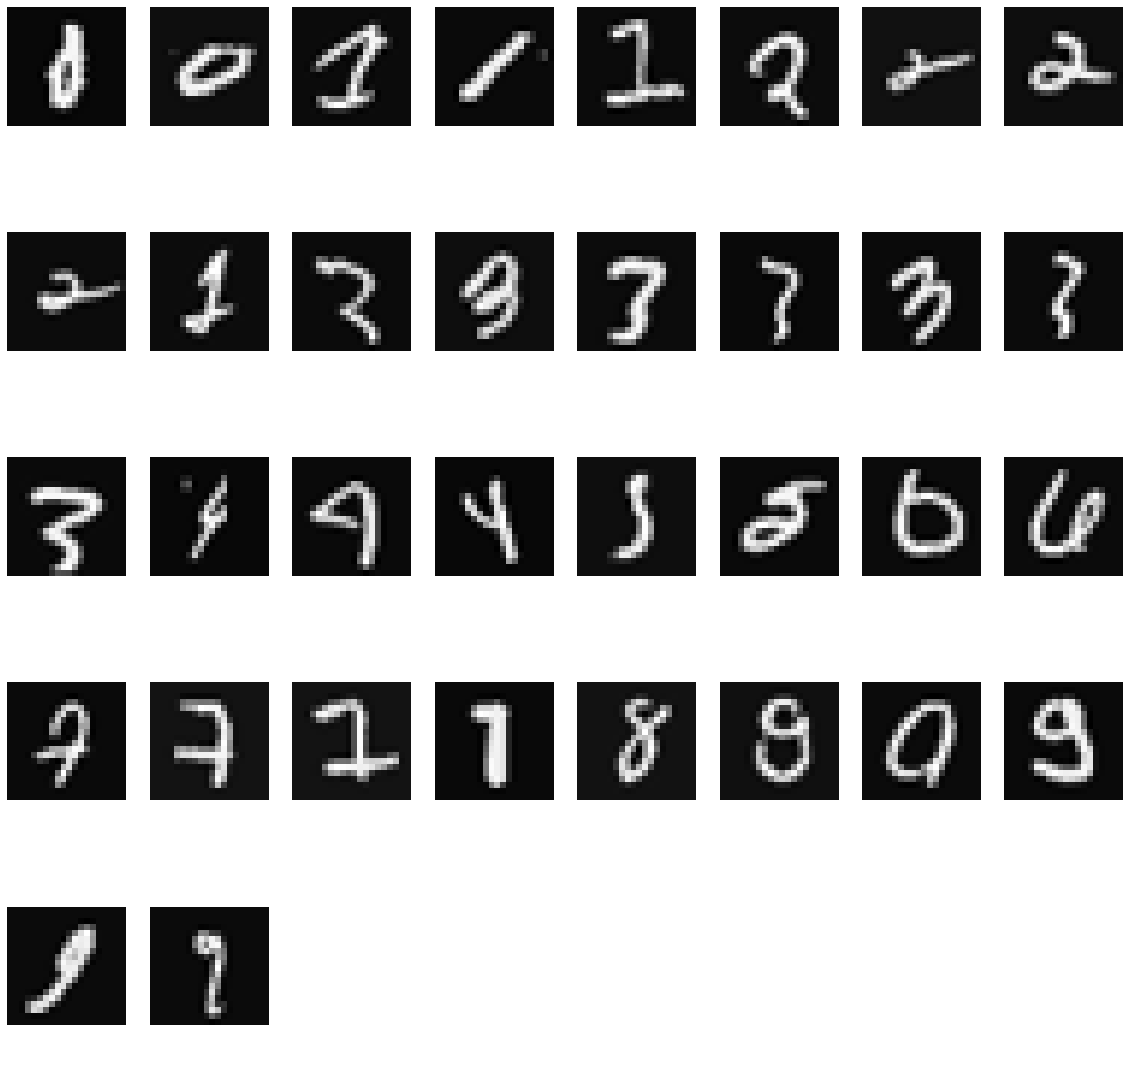

In [196]:
n = 8
fig, axes = plt.subplots(fallos.size//n + (fallos.size%n!=0), n, figsize=(20, 20))

for i in range(len(fallos)):
    index = fallos[i]
    img = X[index, :].reshape(20, 20, order='F')
    axes[i//n, i%n].imshow(img, cmap=plt.cm.gray)
    axes[i//n, i%n].axis('off')
    
for j in range(i%n+1, n):
    axes[i//n, j%n].set_axis_off()
    
    